In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import time

torch.set_default_dtype(torch.float32)

In [89]:
def fk(angles, lengths):

    pos_x = angles[0].cos() * lengths[0]
    pos_y = angles[0].sin() * lengths[0]
    
    pos_x = pos_x + (angles[0] + angles[1]).cos() * lengths[1]
    pos_y = pos_y + (angles[0] + angles[1]).sin() * lengths[1]
    
    pos_x = pos_x + (angles[0] + angles[1] + angles[2]).cos() * lengths[2]
    pos_y = pos_y + (angles[0] + angles[1] + angles[2]).sin() * lengths[2]

    return pos_x, pos_y

def fk_list(angles, lengths):

    pos_list = [[0,0]]

    pos_x = angles[0].cos() * lengths[0]
    pos_y = angles[0].sin() * lengths[0]

    pos_list.append([pos_x.numpy(force=True), pos_y.numpy(force=True)])
    
    pos_x = pos_x + (angles[0] + angles[1]).cos() * lengths[1]
    pos_y = pos_y + (angles[0] + angles[1]).sin() * lengths[1]
    
    pos_list.append([pos_x.numpy(force=True), pos_y.numpy(force=True)])
    
    pos_x = pos_x + (angles[0] + angles[1] + angles[2]).cos() * lengths[2]
    pos_y = pos_y + (angles[0] + angles[1] + angles[2]).sin() * lengths[2]
    
    pos_list.append([pos_x.numpy(force=True), pos_y.numpy(force=True)])

    return pos_list



In [170]:
def ik(
        pos_target, 
        lengths, 
        angles_initial=torch.tensor([0.0, 0.0, 0.0]), 
        angles_prev=None, 
        plot=True, 
        print_iter=False,
        steps=1000,
        lr=0.1,
        momentum=0.9,
        lr_adapt=(0.9, 1.0/0.8),
        phi=0.0,
        phi_weight=0.001,
        phi_std=0.001
    ):

    t_start = time.time()

    lr=0.1
    betas=(0.9, 0.999)

    angles_curr = angles_initial.clone()
    # optimizer = torch.optim.Adam([angles_curr], lr=lr, betas=betas)
    optimizer = torch.optim.SGD([angles_curr], lr=lr, momentum=momentum)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    best_loss = np.inf
    losses = []
    grads = []

    for step in range(steps):

        angles_curr.requires_grad = True

        pos_x, pos_y = fk(angles_curr, lengths)

        dx = pos_x - pos_target[0]
        dy = pos_y - pos_target[1]
        
        distance = (dx**2 + dy**2).sqrt().numpy(force=True)
        if(distance < 0.001):
            break

        loss = dx**2 + dy**2 + torch.abs(dx) + torch.abs(dy)

        # foot angle constraint
        phi_curr = np.pi*0.5-angles_curr.sum()
        # loss += (phi-phi_curr)**2 * (1.0 / (phi_std * np.sqrt(2.0 * np.pi))) * torch.exp(-0.5 * (loss / phi_std)**2) * phi_weight
        loss += (phi-phi_curr)**2 * phi_weight
        
        # keep angles close to zero
        # std = 0.001
        # w0 = 0.1
        # loss += torch.sum(angles_curr**2) * (1.0 / (std * np.sqrt(2.0 * np.pi))) * torch.exp(-0.5 * (loss / std)**2) * w0
        
        # keep angles close to zero
        if(angles_prev is not None):
            std = 0.01
            w0 = 0.01
            loss += torch.max((angles_curr - angles_prev)**2) * (1.0 / (std * np.sqrt(2.0 * np.pi))) * torch.exp(-0.5 * (loss / std)**2) * w0

        # do step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # scheduler.step()

        with torch.no_grad():
            loss_value = loss.numpy(force=True)
            losses.append(loss_value)
            grads.append(angles_curr.grad.abs().sum().numpy(force=True))
        
        if(loss_value > best_loss):
            optimizer.param_groups[0]['lr'] *= lr_adapt[0]
        else:
            optimizer.param_groups[0]['lr'] *= lr_adapt[1]
            best_loss = loss_value

        # print(epoch, loss, angles_curr, loss)
        # print(step, loss, scheduler.get_last_lr())

    t_end = time.time()
    duration = t_end - t_start

    if(print_iter):
        print(f"duration={duration*1000:.2f}ms, steps={step}, distance={distance*1000:.2f}mm, lr={optimizer.param_groups[0]['lr']}")

    if(plot):
        
        matplotlib.rcParams['figure.figsize'] = [8,8]
        fig, axs = plt.subplots(nrows=2)

        ax = axs[0]
        ax.set_title("Loss")
        ax.plot(np.arange(len(losses)), losses, color="black")
        ax.set_yscale("log")
        ax.grid()
        
        ax = axs[1]
        ax.set_title("Gradient")
        ax.plot(np.arange(len(grads)), grads, color="blue")
        ax.set_yscale("log")
        ax.grid()

        plt.show()

    return angles_curr.detach().clone(), optimizer.param_groups[0]['lr']


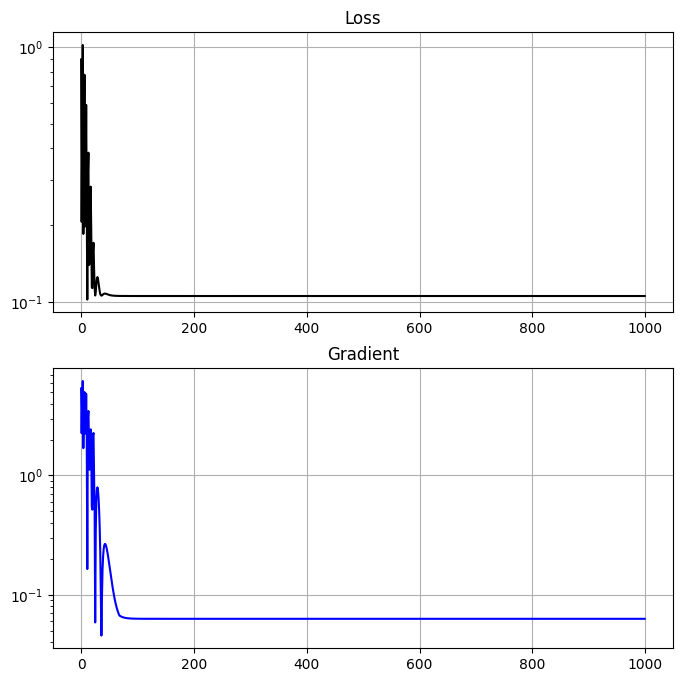

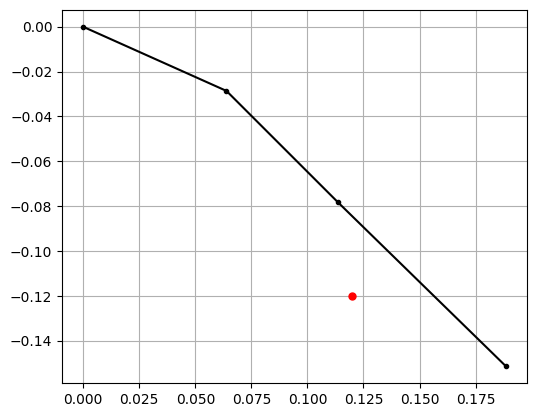

In [171]:
pos_target = torch.tensor([
    # np.random.uniform(0.1, 0.15),
    # np.random.uniform(0.1, 0.15),
    0.12, -0.12
])
lengths = torch.tensor([0.07, 0.07, 0.105], requires_grad=True)
angles_initial = torch.tensor([0.0, 0.0, 0.0])

angles_result, lr = ik(pos_target, lengths, angles_initial, phi=np.pi*0.75, phi_weight=1.0)
pos_list = fk_list(angles_result, lengths)
pos_list = np.array(pos_list)

matplotlib.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()

ax.plot(pos_list[:,0], pos_list[:,1], color="black", ms=3, marker="o")
ax.plot(pos_target[0], pos_target[1], color="red", ms=5, marker="o")
ax.set_aspect("equal")
ax.grid()

plt.show()

In [179]:
pos_target_list = []

n = 20
for i in range(n):
    angle = np.pi*2.0/n*i
    x = 0.08 + np.cos(angle) * 0.03
    y = -0.08 + np.sin(angle) * 0.03
    pos_target_list.append(torch.tensor([x, y]))
    
# pos_target_list.append(torch.tensor([0.01, 0.01]))
# pos_target_list.append(torch.tensor([0.015, 0.015]))
# pos_target_list.append(torch.tensor([-0.015, -0.01]))
# pos_target_list.append(torch.tensor([0.01, 0.01]))

%matplotlib inline

lengths = torch.tensor([0.07, 0.07, 0.105], requires_grad=True)
angles_initial = torch.tensor([
    np.random.uniform(0.1, 0.2),
    np.random.uniform(0.1, 0.2),
    np.random.uniform(0.1, 0.2),
])
angles_prev = None

matplotlib.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()
colormap = matplotlib.colormaps['gist_rainbow']
colors = colormap(np.linspace(0.0, 1.0, len(pos_target_list)))

lr = 0.1
lr_adapt = (1.0, 1.0)
momentum = 0.4

times = []

for i, pos_target in enumerate(pos_target_list):
    
    t_start = time.time()
    angles_result, lr = ik(
        pos_target=pos_target, 
        lengths=lengths, 
        angles_initial=angles_initial, 
        angles_prev=angles_prev, 
        plot=False, 
        print_iter=True,
        steps=1000, 
        lr=lr,
        momentum=momentum, 
        lr_adapt=lr_adapt,
        phi=np.pi*1.0, 
        phi_weight=0.05,
    )
    t_end = time.time()
    duration = t_end - t_start
    times.append(duration)
    
    pos_list = fk_list(angles_result, lengths)
    pos_list = np.array(pos_list)
    
    angles_initial = angles_result.detach().clone()
    # angles_prev = angles_initial.detach().clone()
    
    color = colors[i]

    ax.plot(pos_list[:,0], pos_list[:,1], color=color, ms=3, marker="o")
    ax.plot(pos_target[0], pos_target[1], color="black", ms=5, marker="o")
    
mean = np.mean(times[1:])
std = np.std(times[1:])
print(f"mean={mean*1000:.2f}ms, std={std*1000:.2f}ms")

ax.set_aspect("equal")
ax.grid()

plt.show()





duration=331.44ms, steps=141, distance=0.81mm, lr=0.1
duration=45.87ms, steps=17, distance=0.60mm, lr=0.1
duration=32.95ms, steps=12, distance=0.40mm, lr=0.1
duration=29.51ms, steps=12, distance=0.30mm, lr=0.1
duration=40.94ms, steps=13, distance=0.19mm, lr=0.1
duration=25.97ms, steps=10, distance=0.64mm, lr=0.1
duration=23.98ms, steps=9, distance=0.61mm, lr=0.1
duration=123.56ms, steps=43, distance=0.94mm, lr=0.1
duration=2535.36ms, steps=999, distance=10.31mm, lr=0.1
duration=2128.32ms, steps=999, distance=20.05mm, lr=0.1
duration=2276.70ms, steps=999, distance=29.49mm, lr=0.1


In [105]:
import itertools

params = {
    "momentum": [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0],
    "lr_adapt": [(0.8, 1.4), (0.9, 1.2), (0.95, 1.1), (0.99, 1.02)],
}

keys, values = zip(*params.items())
params_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

params_times = []

print(f"len(params_combinations)={len(params_combinations)}")

for i, params_combination in enumerate(params_combinations):
    
    print(f"i={i}, params_combination={params_combination}")
    
    pos_target_list = []
    lengths = torch.tensor([0.07, 0.07, 0.105], requires_grad=True)
    angles_initial = torch.tensor([0.0, 0.0, 0.0])
    angles_prev = None

    n = 250
    for i in range(n):
        angle = np.pi*2.0/n*i
        x = 0.08 + np.cos(angle) * 0.09
        y = - 0.12 + np.sin(angle) * 0.03
        pos_target_list.append(torch.tensor([x, y]))

    times = []

    lr = 0.1
    momentum = params_combination["momentum"]
    lr_adapt = params_combination["lr_adapt"]

    for j, pos_target in enumerate(pos_target_list):
        
        t_start = time.time()
        angles_result, lr = ik(
            pos_target=pos_target, 
            lengths=lengths, 
            angles_initial=angles_initial, 
            angles_prev=angles_prev, 
            plot=False, 
            steps=1000, 
            lr=lr,
            momentum=momentum, 
            lr_adapt=lr_adapt
        )
        t_end = time.time()
        times.append(t_end-t_start)

        # pos_list = fk_list(angles_result, lengths)
        # pos_list = np.array(pos_list)
        
        angles_initial = angles_result.detach().clone()
        # angles_prev = angles_initial.detach().clone()
        
    times = np.array(times, dtype=np.float64)
    params_times.append(times)
    
    mean = np.mean(times[1:])
    std = np.std(times[1:])
    print(f"mean={mean*1000:.2f}ms, std={std*1000:.2f}ms")

params_times = np.array(params_times, dtype=np.float64)

len(params_combinations)=28
i=0, params_combination={'momentum': 0.0, 'lr_adapt': (0.8, 1.4)}
mean=13.79ms, std=11.22ms
i=1, params_combination={'momentum': 0.0, 'lr_adapt': (0.9, 1.2)}
mean=21.62ms, std=21.28ms
i=2, params_combination={'momentum': 0.0, 'lr_adapt': (0.95, 1.1)}
mean=39.09ms, std=36.84ms
i=3, params_combination={'momentum': 0.0, 'lr_adapt': (0.99, 1.02)}
mean=123.25ms, std=135.96ms
i=4, params_combination={'momentum': 0.2, 'lr_adapt': (0.8, 1.4)}
mean=11.88ms, std=9.61ms
i=5, params_combination={'momentum': 0.2, 'lr_adapt': (0.9, 1.2)}
mean=20.75ms, std=22.65ms
i=6, params_combination={'momentum': 0.2, 'lr_adapt': (0.95, 1.1)}
mean=21.64ms, std=29.99ms
i=7, params_combination={'momentum': 0.2, 'lr_adapt': (0.99, 1.02)}
mean=28.79ms, std=56.80ms
i=8, params_combination={'momentum': 0.4, 'lr_adapt': (0.8, 1.4)}
mean=9.00ms, std=7.82ms
i=9, params_combination={'momentum': 0.4, 'lr_adapt': (0.9, 1.2)}
mean=7.11ms, std=8.08ms
i=10, params_combination={'momentum': 0.4, 'lr_ad

In [106]:
for i, params_combination in enumerate(params_combinations):

    times = params_times[i]
    mean = np.mean(times[1:])
    std = np.std(times[1:])

    print(f"i={i}, params_combination={params_combination}, mean={mean*1000:.2f}ms, std={std*1000:.2f}ms")


i=0, params_combination={'momentum': 0.0, 'lr_adapt': (0.8, 1.4)}, mean=13.79ms, std=11.22ms
i=1, params_combination={'momentum': 0.0, 'lr_adapt': (0.9, 1.2)}, mean=21.62ms, std=21.28ms
i=2, params_combination={'momentum': 0.0, 'lr_adapt': (0.95, 1.1)}, mean=39.09ms, std=36.84ms
i=3, params_combination={'momentum': 0.0, 'lr_adapt': (0.99, 1.02)}, mean=123.25ms, std=135.96ms
i=4, params_combination={'momentum': 0.2, 'lr_adapt': (0.8, 1.4)}, mean=11.88ms, std=9.61ms
i=5, params_combination={'momentum': 0.2, 'lr_adapt': (0.9, 1.2)}, mean=20.75ms, std=22.65ms
i=6, params_combination={'momentum': 0.2, 'lr_adapt': (0.95, 1.1)}, mean=21.64ms, std=29.99ms
i=7, params_combination={'momentum': 0.2, 'lr_adapt': (0.99, 1.02)}, mean=28.79ms, std=56.80ms
i=8, params_combination={'momentum': 0.4, 'lr_adapt': (0.8, 1.4)}, mean=9.00ms, std=7.82ms
i=9, params_combination={'momentum': 0.4, 'lr_adapt': (0.9, 1.2)}, mean=7.11ms, std=8.08ms
i=10, params_combination={'momentum': 0.4, 'lr_adapt': (0.95, 1.1)}